In [27]:
import torch
import math
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, Set2 as NodeColors
from time import time
from scipy.ndimage import spline_filter, zoom
from interpol.regularizers import flowreg, make_evalkernels1d, flow_upsample2
from interpol import resize, spline_coeff_nd, grid_grad, grid_hess, identity_grid, grid_pull


BOUND = 'circulant'
ANCHOR = 'edge'
NDIM = 1
ORDER = 3
NORM = True
SHAPE = 16
MAXFAC = 4
USE_SCIPY = False

# sample spline coefficients on a coarse grid
fullshape = [SHAPE] * NDIM + [NDIM]
coeff = torch.randn(*fullshape, dtype=torch.float64) * SHAPE / 4

# coarse to fine pyramid of grids
factors = torch.linspace(0, MAXFAC, 32).tolist()
shapes = [int(round(SHAPE * 2**f)) for f in factors]
# I make it so the voxel size is 1 when the grid is 128, because of
# instabilities obsered when working with tiny voxel sizes (I think
# when taking 1/vx**2 during scaling of the derivatives)
vxs = [2 * 128 / round(SHAPE * 2**f) for f in factors]
VX = vxs[0]

intfactors = list(range(MAXFAC+1))
intshapes = [int(round(SHAPE * 2**f)) for f in intfactors]
intvxs = [2 * 128 / round(SHAPE * 2**f) for f in intfactors]

absolute_exact, absolute_approx, absolute_fd = [], [], []
membrane_exact, membrane_approx, membrane_fd = [], [], []
bending_exact, bending_approx, bending_fd = [], [], []
div_exact, div_approx, div_fd = [], [], []

time_absolute_exact, time_absolute_approx, time_absolute_fd = [], [], []
time_membrane_exact, time_membrane_approx, time_membrane_fd = [], [], []
time_bending_exact, time_bending_approx, time_bending_fd = [], [], []
time_div_exact, time_div_approx, time_div_fd = [], [], []
time_resize, time_coeff, time_evalgrad, time_evalhess, time_grid = [], [], [], [], []

for shape, vx in zip(shapes, vxs):
    if USE_SCIPY:
        # To check if the downtick observed when resampling to a coarse
        # grid is caused by my interpolation code, I tried using pure
        # scipy instead, but found the same effect
        tic = time()
        flow = torch.stack([
            torch.as_tensor(zoom(c, shape/SHAPE, order=ORDER, grid_mode=True,
                                mode='grid-wrap' if BOUND == 'circulant' else 'grid-mirror'))
            for c in coeff.unbind(-1)
        ], -1).mul_(shape/SHAPE)
        tac = time()
        time_resize += [tac - tic]
        coeff1 = torch.stack([
            torch.as_tensor(spline_filter(f, ORDER, mode='grid-wrap' if BOUND == 'circulant' else 'grid-mirror'))
            for f in flow.unbind(-1)
        ], -1)
        toc = time()
        time_coeff += [toc - tac]
    else:
        # This uses torch-interpol instead of scipy.ndimage
        tic = time()
        flow = resize(
            coeff.movedim(-1, 0), shape=[shape]*NDIM,
            anchor=ANCHOR, interpolation=ORDER, prefilter=False, bound=BOUND
        ).movedim(0, -1)  # .mul_(shape/SHAPE)
        tac = time()
        time_resize += [tac - tic]
        coeff1 = spline_coeff_nd(
            flow.movedim(-1, 0), interpolation=ORDER, bound=BOUND, dim=NDIM
        ).movedim(0, -1)
        toc = time()
        time_coeff += [toc - tac]
        flow *= shape/SHAPE
        coeff1 *= shape/SHAPE
    # make sampling grid + eval grad/hess
    tic = time()
    grid = identity_grid([shape]*NDIM)
    grid *= SHAPE/shape
    grid += 0.5 * (SHAPE/shape - 1)
    time_grid += [time() - tic]
    tic = time()
    grad = grid_grad(coeff.movedim(-1, 0), grid, ORDER, BOUND, True, False).movedim(0, -2)
    time_evalgrad += [time() - tic]
    tic = time()
    hess = grid_hess(coeff.movedim(-1, 0), grid, ORDER, BOUND, True, False).movedim(0, -3)
    time_evalhess += [time() - tic]
    evalabs = flow.square().sum()
    evalmem = grad.square().sum()
    evalben = hess.square().sum()
    evaldiv = grad.diagonal(0, -1, -2).sum(-1).square().sum()
    if NORM:
        evalabs *= (vx*vx) / (2*shape**NDIM)
        evalmem /= (2*shape**NDIM)
        evalben /= (2*VX*VX*shape**NDIM)
        evaldiv /= (2*shape**NDIM)
    else:
        evalabs *= 0.5 * (vx**4)
        evalmem *= 0.5 * (vx*vx)
        evalben *= 0.5 * (vx*vx) / (VX*VX)
        evaldiv *= 0.5 * (vx*vx)
    # compute energies
    tic = time()
    absolute_exact += [flowreg(coeff1, ORDER, bound=BOUND, absolute=1, norm=NORM, voxel_size=vx)]
    time_absolute_exact += [time() - tic]
    tic = time()
    membrane_exact += [flowreg(coeff1, ORDER, bound=BOUND, membrane=1, norm=NORM, voxel_size=vx)]
    time_membrane_exact += [time() - tic]
    tic = time()
    bending_exact += [flowreg(coeff1, ORDER, bound=BOUND, bending=1, norm=NORM, voxel_size=vx)]
    time_bending_exact += [time() - tic]
    tic = time()
    div_exact += [flowreg(coeff1, ORDER, bound=BOUND, div=1, norm=NORM, voxel_size=vx)]
    time_div_exact += [time() - tic]
    # tic = time()
    # absolute_approx += [flowreg(coeff1, ORDER, bound=BOUND, absolute=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    # time_absolute_approx += [time() - tic]
    # tic = time()
    # membrane_approx += [flowreg(coeff1, ORDER, bound=BOUND, membrane=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    # time_membrane_approx += [time() - tic]
    # tic = time()
    # bending_approx += [flowreg(coeff1, ORDER, bound=BOUND, bending=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    # time_bending_approx += [time() - tic]
    # tic = time()
    # div_approx += [flowreg(coeff1, ORDER, bound=BOUND, div=1, norm=NORM, voxel_size=vx, kernels1d=make_evalkernels1d(ORDER))]
    # time_div_approx += [time() - tic]
    absolute_approx += [evalabs]
    time_absolute_approx += [time_resize[-1]]
    membrane_approx += [evalmem]
    time_membrane_approx += [time_grid[-1] + time_evalgrad[-1]]
    bending_approx += [evalben]
    time_bending_approx += [time_grid[-1] + time_evalhess[-1]]
    div_approx += [evaldiv]
    time_div_approx += [time_grid[-1] + time_evalgrad[-1]]
    tic = time()
    absolute_fd += [flowreg(flow, 'fd', bound=BOUND, absolute=1, norm=NORM, voxel_size=vx)]
    time_absolute_fd += [time() - tic]
    tic = time()
    membrane_fd += [flowreg(flow, 'fd', bound=BOUND, membrane=1, norm=NORM, voxel_size=vx)]
    time_membrane_fd += [time() - tic]
    tic = time()
    bending_fd += [flowreg(flow, 'fd', bound=BOUND, bending=1, norm=NORM, voxel_size=vx)]
    time_bending_fd += [time() - tic]
    tic = time()
    div_fd += [flowreg(flow, 'fd', bound=BOUND, div=1, norm=NORM, voxel_size=vx)]
    time_div_fd += [time() - tic]

In [21]:
import torch
import math
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, Set2 as NodeColors
from time import time
from scipy.ndimage import spline_filter, zoom
from interpol.regularizers import flowreg, make_evalkernels1d, flow_upsample2
from interpol import resize, spline_coeff_nd, grid_grad, grid_hess, identity_grid


BOUND = 'circulant'
ANCHOR = 'edge'
NDIM = 1
ORDER = 3
NORM = True
SHAPE = 16
MAXFAC = 4
USE_SCIPY = False

# sample spline coefficients on a coarse grid
# coeff = torch.randn(SHAPE, SHAPE, 2, dtype=torch.float64) * SHAPE / 4

intfactors = list(range(MAXFAC+1))
intshapes = [int(round(SHAPE * 2**f)) for f in intfactors]
intvxs = [2 * 128 / round(SHAPE * 2**f) for f in intfactors]

int_absolute_exact, int_membrane_exact, int_bending_exact, int_div_exact = [], [], [], []

for shape, vx in zip(intshapes, intvxs):
    coeff1 = coeff
    logfactor = int(math.log2(shape//SHAPE))
    for _ in range(logfactor):
        coeff1 = flow_upsample2(coeff1, order=ORDER, bound=BOUND)

    # if NDIM == 1:
    #     x = torch.linspace(-0.5, len(coeff1)-0.5, 256)
    #     plt.plot(resize(coeff1.squeeze(), shape=[256], interpolation=ORDER, bound=BOUND, prefilter=False, anchor='e') / 2**logfactor)
    #     # plt.plot(grid_pull(coeff1.movedim(-1, 0), x[:, None], interpolation=ORDER, bound=BOUND).squeeze() / 2**logfactor)
    #     plt.show()
    # elif NDIM == 2:
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(resize(coeff1[..., 0], shape=[256, 256], interpolation=ORDER, bound=BOUND, prefilter=False, anchor='e') / 2**logfactor)
    #     plt.colorbar()
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(resize(coeff1[..., 1], shape=[256, 256], interpolation=ORDER, bound=BOUND, prefilter=False, anchor='e') / 2**logfactor)
    #     plt.colorbar()
    #     plt.show()
    # compute energies
    int_absolute_exact += [flowreg(coeff1, ORDER, bound=BOUND, absolute=1, norm=NORM, voxel_size=vx)]
    int_membrane_exact += [flowreg(coeff1, ORDER, bound=BOUND, membrane=1, norm=NORM, voxel_size=vx)]
    int_bending_exact += [flowreg(coeff1, ORDER, bound=BOUND, bending=1, norm=NORM, voxel_size=vx)]
    int_div_exact += [flowreg(coeff1, ORDER, bound=BOUND, div=1, norm=NORM, voxel_size=vx)]

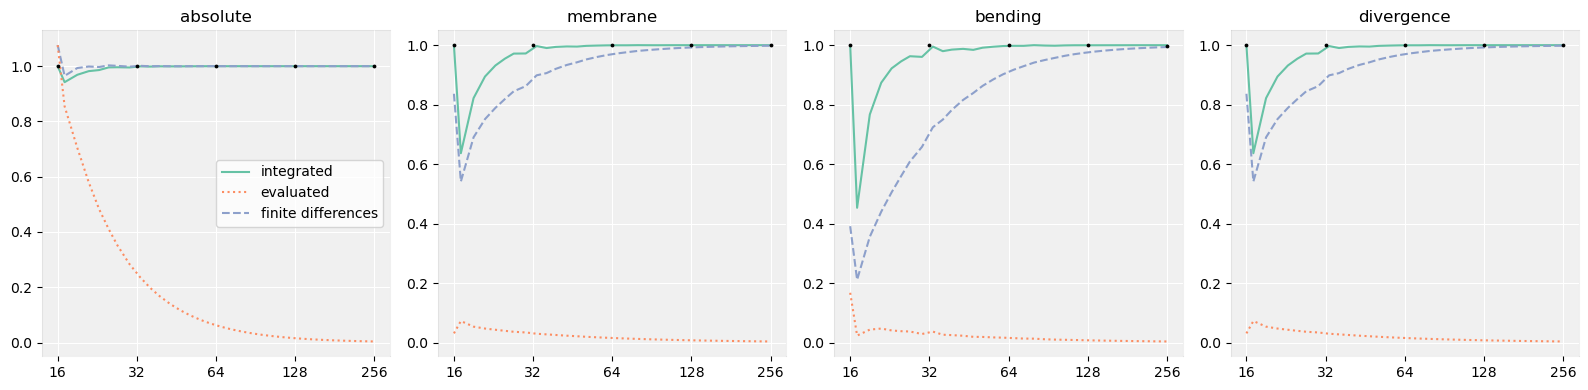

In [28]:

plt.figure(figsize=(16, 4))
colors = NodeColors(range(4))

gridshape = (1, 4)

# plt.set_cmap()
plt.subplot(*gridshape, 1)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_approx)), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / absolute_exact[0], absolute_fd)), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / int_absolute_exact[0], int_absolute_exact)), 3, 'k', zorder=1000)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
# plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences'])
plt.title('absolute')

plt.subplot(*gridshape, 2)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / membrane_exact[0], membrane_fd)), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / int_membrane_exact[0], int_membrane_exact)), 3, 'k', zorder=1000)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('membrane')

plt.subplot(*gridshape, 3)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / bending_exact[0], bending_fd)), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / int_bending_exact[0], int_bending_exact)), 3, 'k', zorder=1000)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')

plt.subplot(*gridshape, 4)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / div_exact[0], div_fd)), '--', color=colors[2])
plt.scatter(intshapes, list(map(lambda x: x / int_div_exact[0], int_div_exact)), 3, 'k', zorder=1000)
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/errors.pdf')
plt.show()

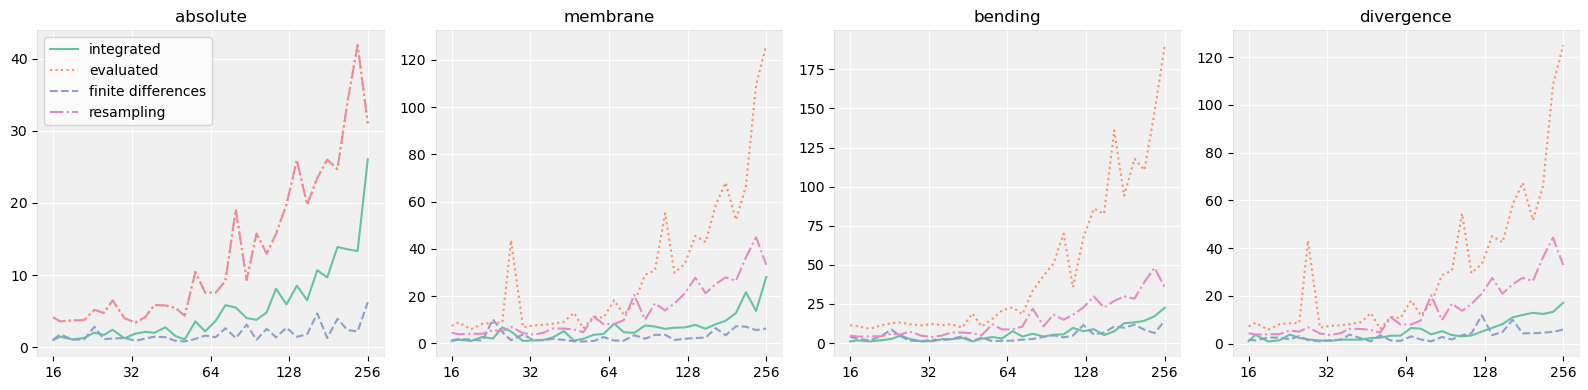

In [15]:

plt.figure(figsize=(16, 4))
colors = NodeColors(range(5))

gridshape = (1, 4)

# plt.set_cmap()
plt.subplot(*gridshape, 1)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_absolute_exact[0], time_absolute_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_absolute_exact[0], time_absolute_approx)), ':', color=colors[1], zorder=100)
plt.plot(shapes, list(map(lambda x: x / time_absolute_exact[0], time_absolute_fd)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_absolute_exact[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
# plt.gca().tick_params(axis='x', color='w')
plt.minorticks_off()
plt.legend(['integrated', 'evaluated', 'finite differences', 'resampling'])
plt.title('absolute')

plt.subplot(*gridshape, 2)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_membrane_exact[0], time_membrane_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_membrane_exact[0], time_membrane_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_membrane_exact[0], time_membrane_fd)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_membrane_exact[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
# plt.gca().set_yscale('log')
# plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)], [''] * (MAXFAC+1))
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('membrane')

plt.subplot(*gridshape, 3)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_bending_exact[0], time_bending_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_bending_exact[0], time_bending_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_bending_exact[0], time_bending_fd)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_bending_exact[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().set_yscale('log')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('bending')

plt.subplot(*gridshape, 4)
plt.grid(color='white')
plt.plot(shapes, list(map(lambda x: x / time_div_exact[0], time_div_exact)), color=colors[0])
plt.plot(shapes, list(map(lambda x: x / time_div_exact[0], time_div_approx)), ':', color=colors[1])
plt.plot(shapes, list(map(lambda x: x / time_div_exact[0], time_div_fd)), '--', color=colors[2])
plt.plot(shapes, list(map(lambda x: x / time_div_exact[0], time_resize)), '-.', color=colors[3])
plt.gca().set_xscale('log')
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.xticks([SHAPE * 2**f for f in range(MAXFAC+1)],
           map(str, [SHAPE * 2**f for f in range(MAXFAC+1)]))
plt.minorticks_off()
plt.title('divergence')


plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/speed.pdf')
plt.show()